In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import os
from datetime import datetime
from dateutil import relativedelta
from tqdm import tqdm
from pathlib import Path
import json
from multiprocessing import Pool
from tqdm import tqdm

from datetime import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from utils import *
from local_testing import *

In [5]:
def get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=1, grafico=True): 

    dda = get_dda(linea, base=False, AC=False)

    obsoletos_dict = dict()
    for date in dda.iloc[:,:-years_obsoleto*12+1].columns:
        fechas = months_between_list(date, date_add_months(date, years_obsoleto*12))
        df_dda = dda[fechas]
        obsoletos_dict[date] = list(df_dda[df_dda.sum(axis=1)==0].index)
    obsoletos_n = {key:len(value) for (key,value) in obsoletos_dict.items()}
    
    if years_dda_previa>0:
        dda_previa_dict = dict()
        for date in dda.iloc[:,years_dda_previa*12:].columns:
            fechas = months_between_list(date_add_months(date, -years_dda_previa*12), date)
            df_dda = dda[fechas]
            dda_previa_dict[date] = list(df_dda[df_dda.sum(axis=1)>0].index)
        dda_previa_n = {key:len(value) for (key,value) in dda_previa_dict.items()}

        dates = ordenar_fechas(list(set(obsoletos_dict.keys()).intersection(set(dda_previa_dict.keys()))))
    
        PNs = dict()
        for date in dates:
            if years_dda_previa>0:
                PNs[date] = list(set(obsoletos_dict[date]).intersection(set(dda_previa_dict[date])))         
                
    if years_dda_previa==0:
        PNs = obsoletos_dict
                  
    PNs_n = {key:len(value) for (key,value) in PNs.items()}
    
    if grafico==True:
        df = pd.DataFrame.from_dict(PNs_n, orient='index')
        df.columns = ['PNs']

        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=df.index,
            y=df.PNs,
            name='Primary Product',
            marker_color='indianred'
        ))
        fig.update_layout(barmode='group',
                          title="Cantidad de PNs obsoletos: Obsolescencia="+ str(years_obsoleto) + 'yrs, Demanda Previa=' + str(years_dda_previa) + "yrs, " + linea,
                          yaxis_title="Unidades")
        
        fig.show()
        
    return PNs, PNs_n

In [6]:
linea = 'SSC'

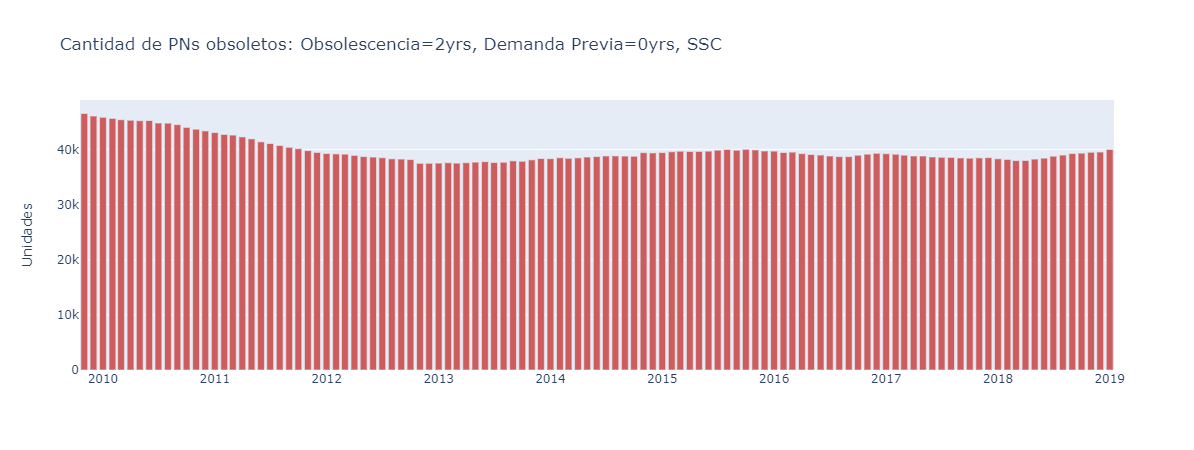

In [8]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=0, grafico=True)

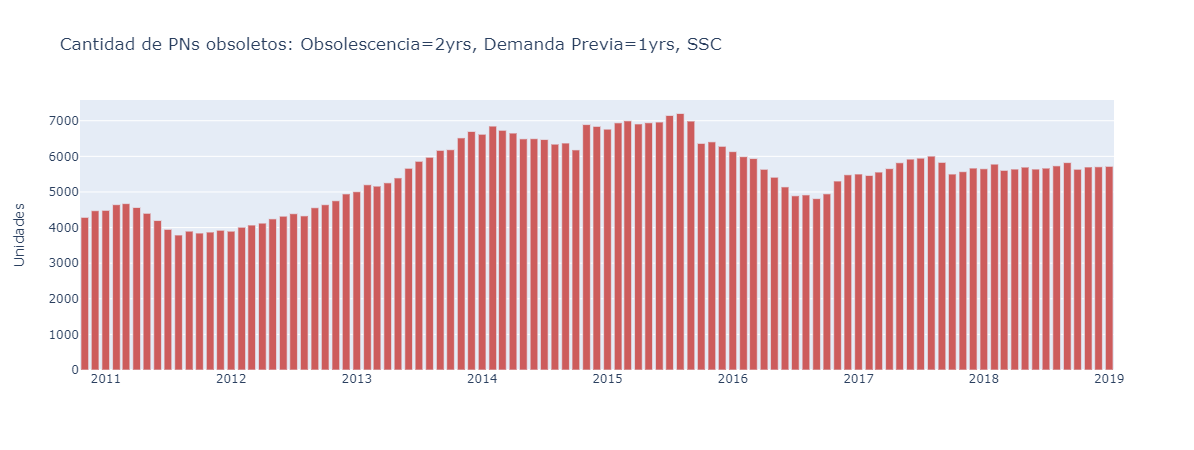

In [221]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=1, grafico=True)

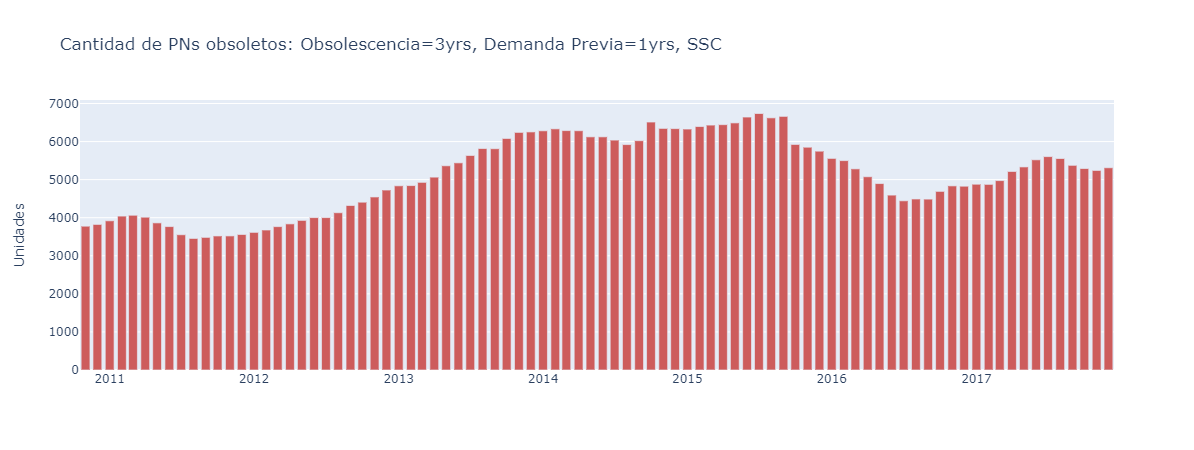

In [172]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=3, years_dda_previa=1, grafico=True)

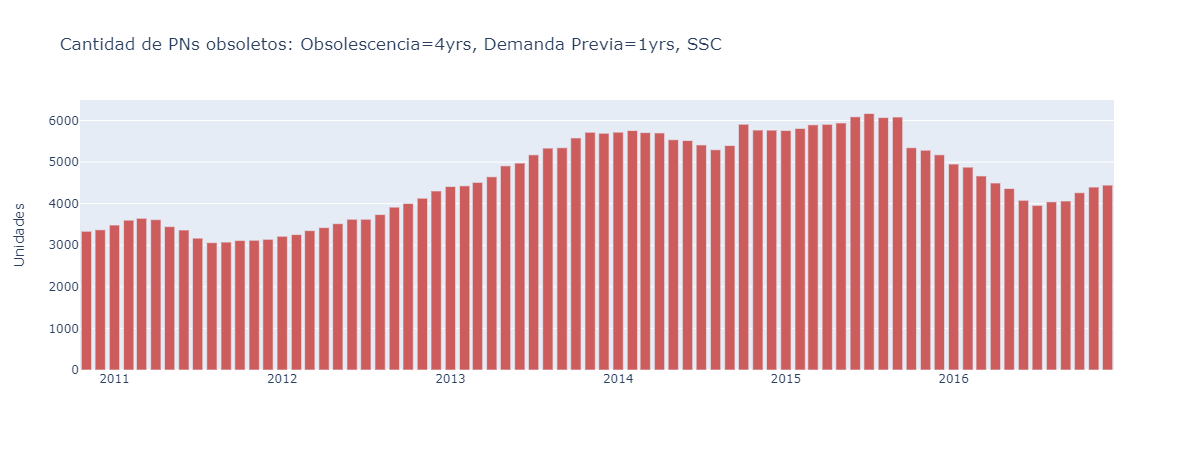

In [174]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=4, years_dda_previa=1, grafico=True)

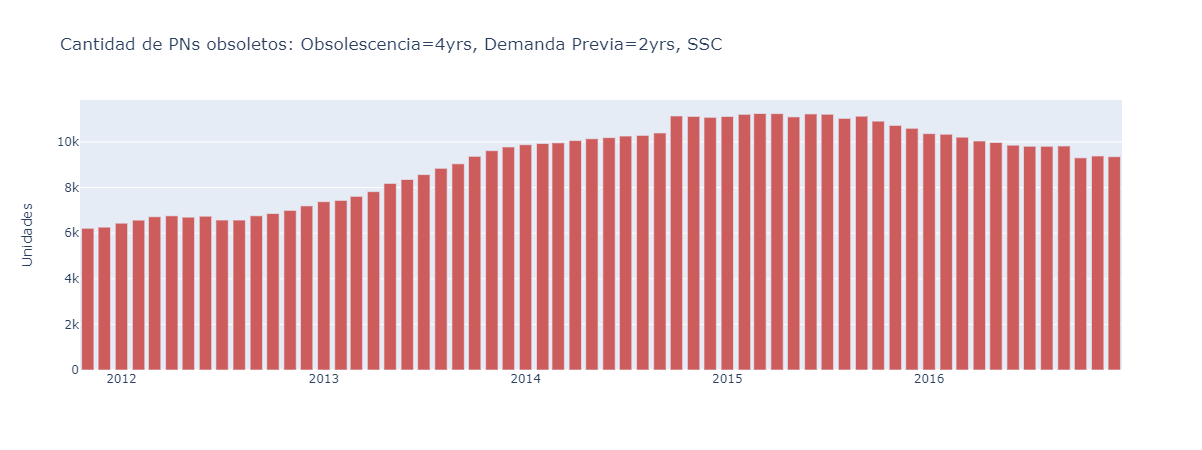

In [178]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=4, years_dda_previa=2, grafico=True)

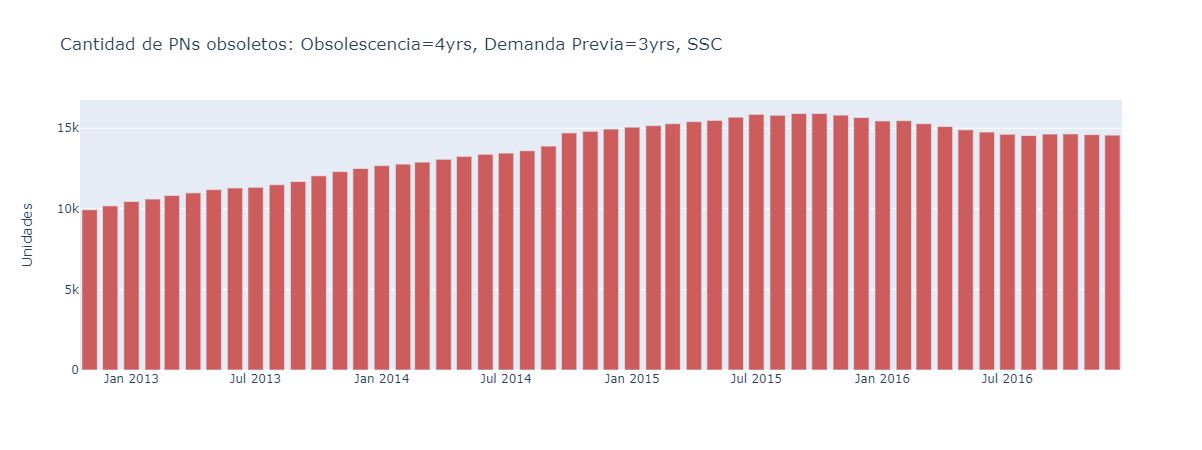

In [179]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=4, years_dda_previa=3, grafico=True)

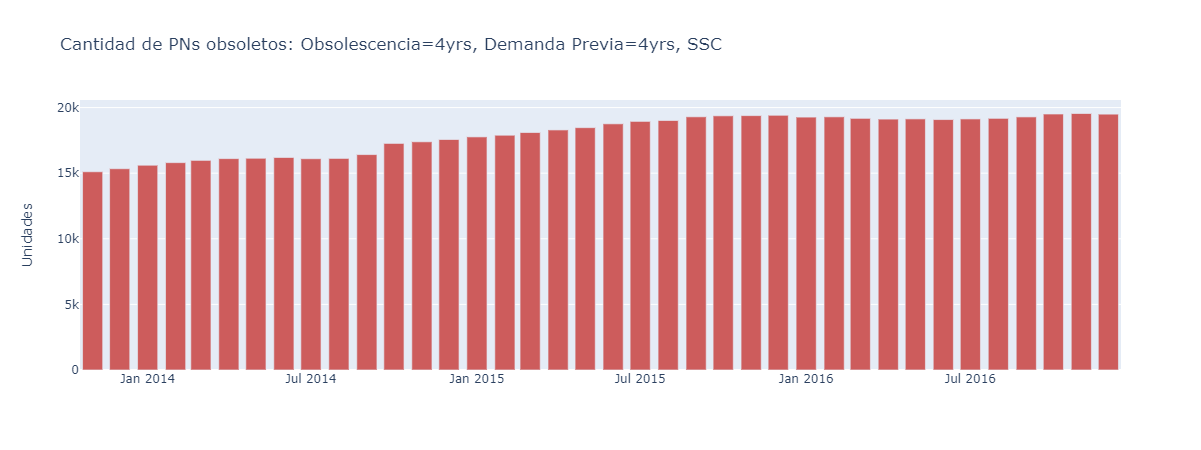

In [180]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=4, years_dda_previa=4, grafico=True)

# Ahorros

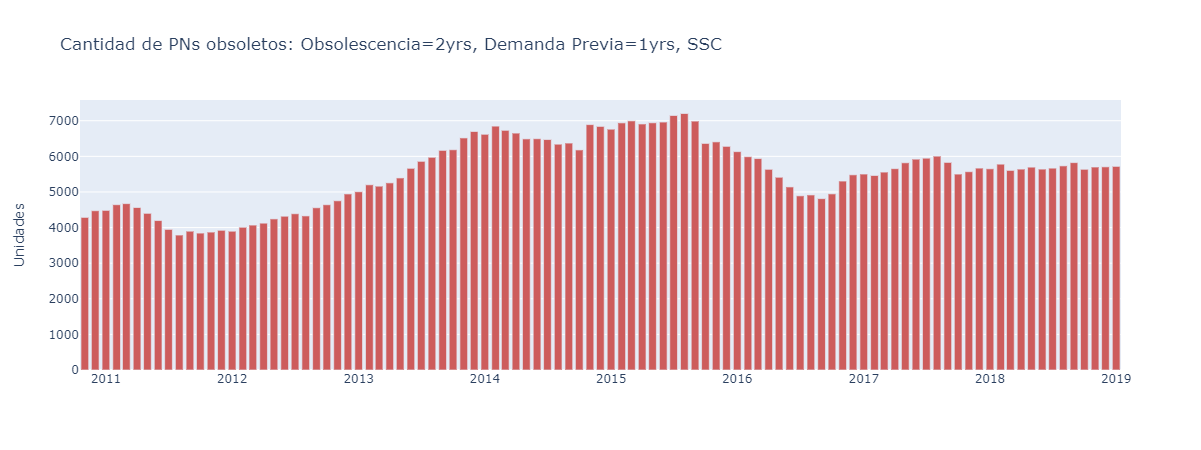

In [462]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=1, grafico=True)

In [463]:
FC='CV_1'
linea='SSC'
date = '2019-01-01'
print(FC, linea)

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea, date)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

diccio_da = dict()
diccio_da['AA'] = fc_aa['FC'].sum()
diccio_da['BP'] = fc_bp['FC'].sum()

diccio_pq = dict()
diccio_pq['AA'] = fc_aa['PQ'].sum()
diccio_pq['BP'] = fc_bp['PQ'].sum()

CV_1 SSC
DA
AA :  26461.96423980395
BP :  122935.04916680706
PQ
AA :  1770678.851103556
BP :  11253248.37179073


In [464]:
df_da = pd.DataFrame.from_dict(diccio_da, orient='index')
df_da.columns = ['DA']

df_pq = pd.DataFrame.from_dict(diccio_pq, orient='index')
df_pq.columns = ['PQ']

df = df_da.merge(df_pq, left_index=True, right_index=True)
df.reset_index(inplace=True)

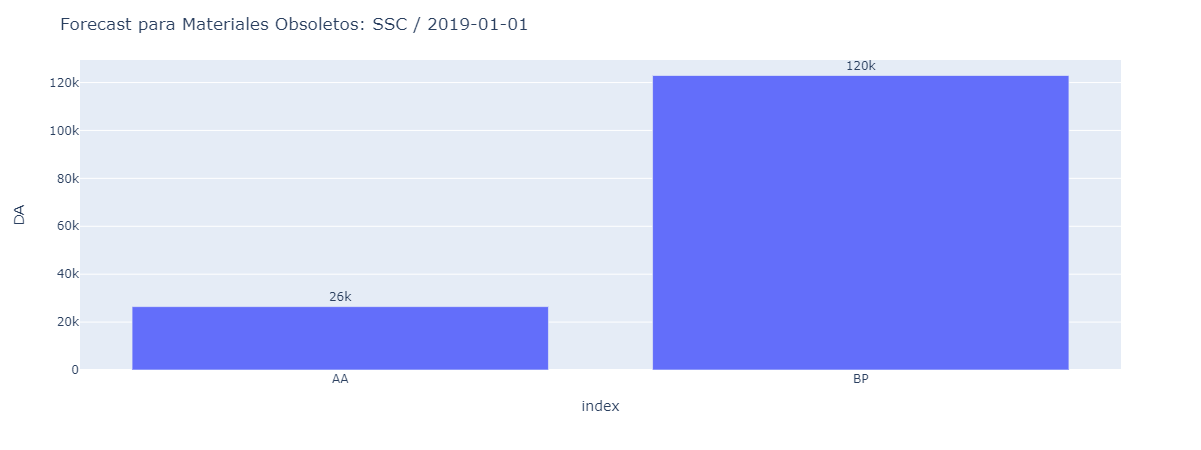

In [469]:
fig = px.bar(df, x='index', y='DA', text='DA')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.update_layout(title_text='Forecast para Materiales Obsoletos: ' + linea + ' / ' + date)
fig.show()

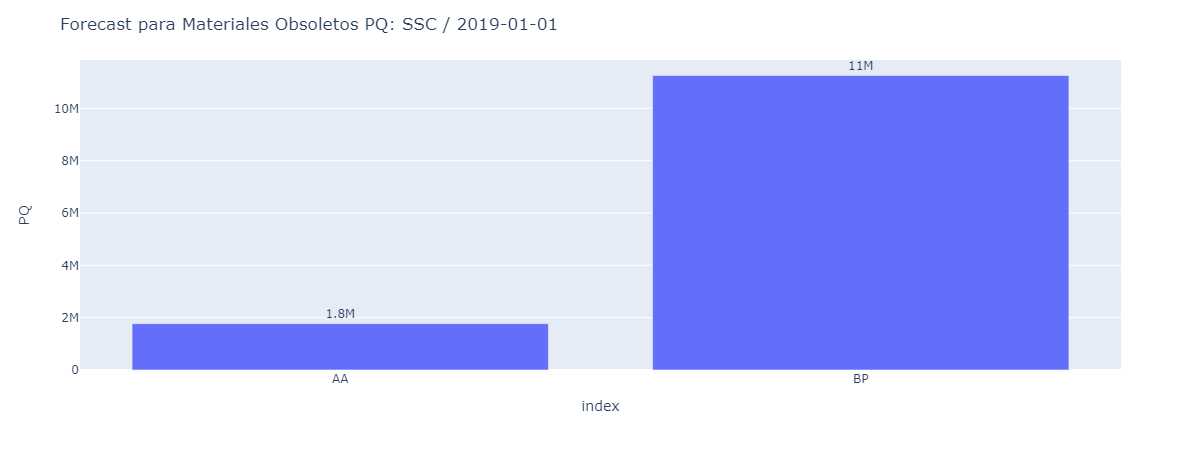

In [466]:
fig = px.bar(df, x='index', y='PQ', text='PQ')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Forecast para Materiales Obsoletos PQ: ' + linea + ' / ' + date)
fig.show()

In [455]:
linea='MRO'

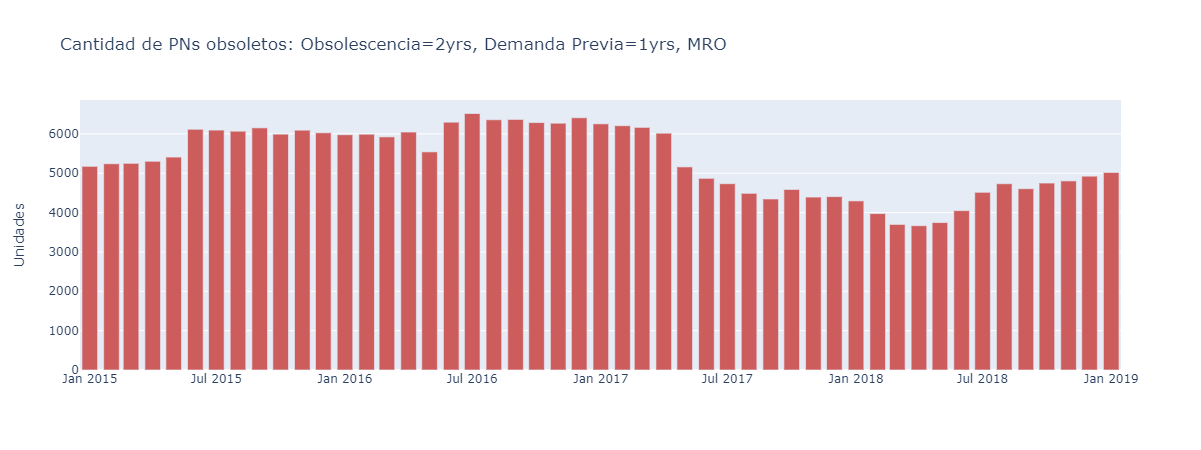

In [456]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=1, grafico=True)

In [457]:
FC='CV_1'
print(FC, linea)
date = '2019-01-01'

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea, date)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_AVG_PRICE']] # 'RC_CLASS_SUPPLY', 
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

diccio_da = dict()
diccio_da['AA'] = fc_aa['FC'].sum()
diccio_da['BP'] = fc_bp['FC'].sum()

diccio_pq = dict()
diccio_pq['AA'] = fc_aa['PQ'].sum()
diccio_pq['BP'] = fc_bp['PQ'].sum()

CV_1 MRO
DA
AA :  7676.05921593884
BP :  22629.730199999998
PQ
AA :  2090463.0560536466
BP :  10683461.051358


In [458]:
df_da = pd.DataFrame.from_dict(diccio_da, orient='index')
df_da.columns = ['DA']

df_pq = pd.DataFrame.from_dict(diccio_pq, orient='index')
df_pq.columns = ['PQ']

df = df_da.merge(df_pq, left_index=True, right_index=True)
df.reset_index(inplace=True)

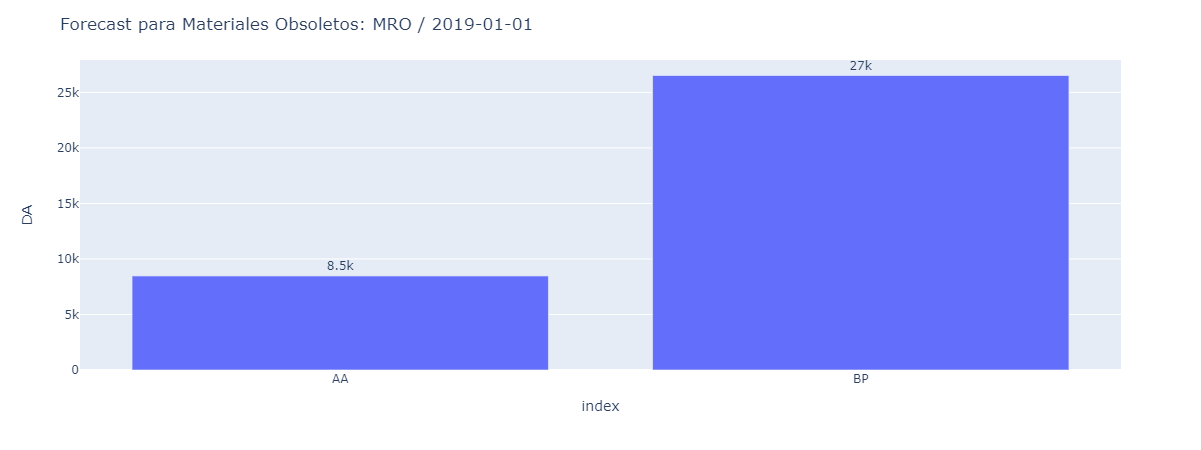

In [459]:
fig = px.bar(df, x='index', y='DA', text='DA')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Forecast para Materiales Obsoletos: ' + linea + ' / ' + date)
fig.show()

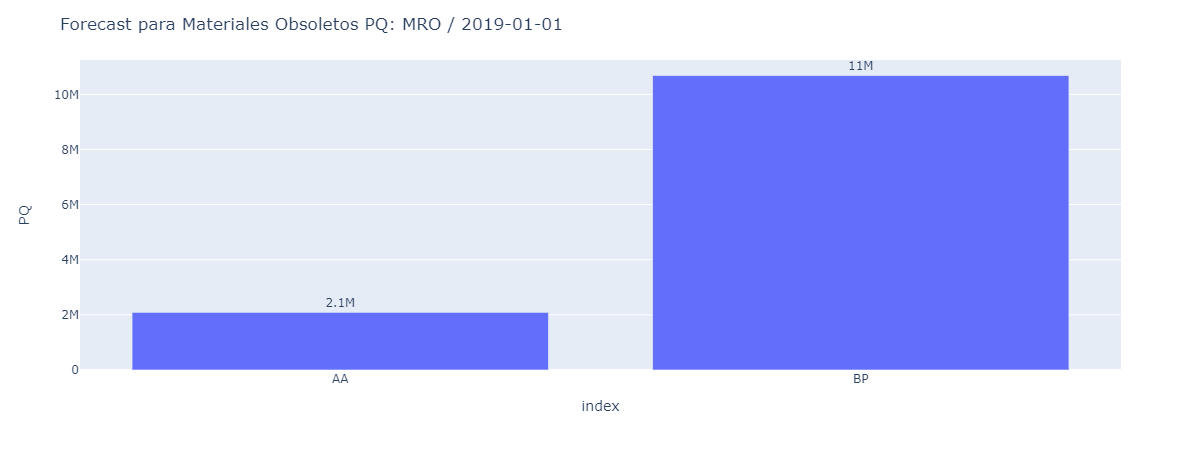

In [460]:
fig = px.bar(df, x='index', y='PQ', text='PQ')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(title_text='Forecast para Materiales Obsoletos PQ: ' + linea + ' / ' + date)
fig.show()

In [424]:
date = '2019-08-01' 
linea='BRA'

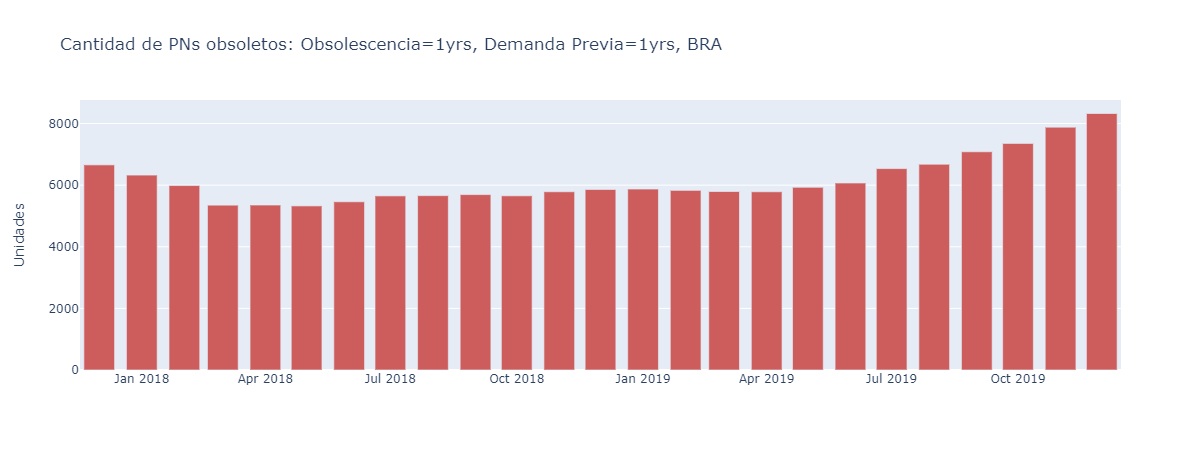

In [425]:
PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=1, years_dda_previa=1, grafico=True)

In [426]:
FC='AA'
print(FC, linea)

# fc_aa = get_local_fc(linea, FC, date)
fc_aa = get_fc(linea, FC)
fc_aa = fc_aa[fc_aa.date==date]
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea, date)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

AA BRA
DA
AA :  0.0
BP :  46723.92
PQ
AA :  0.0
BP :  23106714.57069146


In [392]:
FC = 'AA'
linea='SSC'
print(FC, linea)

fc_aa = get_fc(linea, partner='AA', AC=False)
fc_aa = fc_aa[np.logical_and(fc_aa.REF_CODE.isin(PNs[date]), fc_aa.date==date)]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[fc_bp.REF_CODE.isin(fc_aa.REF_CODE)]
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

AA SSC
DA
AA :  25994.069409351712
BP :  133148.03192936414
PQ
AA :  1668729.7055975592
BP :  22170154.54204385


In [393]:
FC = 'CV_1'
linea='SSC'
print(FC, linea)

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
# fc_bp = fc_bp[fc_bp.REF_CODE.isin(fc_aa.REF_CODE)]
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

CV_1 SSC
DA
AA :  29462.860387630797
BP :  134599.61583347374
PQ
AA :  3689359.3103318685
BP :  22581210.287441734


In [394]:
FC = 'CV_OUTLIERS'
linea = 'SSC'
print(FC, linea)

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
# fc_bp = fc_bp[fc_bp.REF_CODE.isin(fc_aa.REF_CODE)]
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

CV_OUTLIERS SSC
DA
AA :  225120.04479664352
BP :  134599.61583347374
PQ
AA :  61301537.33361852
BP :  22581210.287441734


In [398]:
FC = 'CV_with_outliers'
linea='SSC'

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
# fc_bp = fc_bp[fc_bp.REF_CODE.isin(fc_aa.REF_CODE)]
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

fc_aa

# masterdata = get_masterdata(linea)
# masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
# masterdata.dropna(inplace=True)
# masterdata.drop_duplicates(inplace=True)
# masterdata.head(5)

# fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
# fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

# fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
# fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

# print('PQ')
# print('AA : ', fc_aa.PQ.sum())
# print('BP : ', fc_bp.PQ.sum())

DA
AA :  155883.79893445165
BP :  134599.61583347374


,REF_CODE,date,FC
3,DELETE_M83248-1-008,2019-01-01,114.304321
4,2-1461-00-000,2019-01-01,2.639196
5,TF101546,2019-01-01,315.366580
13,EL8-608,2019-01-01,14.217846
15,LA-14-041,2019-01-01,0.309031
...,...,...,...
988,4-0796-01-000,2019-01-01,203.725631
990,71-912500-GEN,2019-01-01,2.813790
992,9EL200896-01,2019-01-01,0.168235
993,D3611020600000,2019-01-01,0.343312


In [395]:
FC='MPARAMS'
linea='SSC'
print(FC, linea)

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

MPARAMS SSC
DA
AA :  26509.681239421167
BP :  134599.61583347374
PQ
AA :  1978011.5308320385
BP :  22581210.287441734


In [396]:
FC='MPARAMS'
linea='SSC'
print(FC, linea)

PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=1, grafico=False)
print(PNs_n[date])

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

MPARAMS SSC
5719
DA
AA :  26167.842069710685
BP :  122935.04916680706
PQ
AA :  1818036.7153589367
BP :  11253248.37179073


In [397]:
FC='MPARAMS'
linea='SSC'
print(FC, linea)

PNs, PNs_n = get_def_obsoletos(linea, years_obsoleto=2, years_dda_previa=2, grafico=False)
print(PNs_n[date])

fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]
fc_aa['FC'] = fc_aa[[col for col in fc_aa.columns if col.find('_')==0]].sum(axis=1)
fc_aa = fc_aa[['REF_CODE', 'date', 'FC']]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]
fc_bp['FC'] = fc_bp[[col for col in fc_bp.columns if col.find('_')==0]].sum(axis=1)
fc_bp = fc_bp[['REF_CODE', 'date', 'FC']]

print('DA')
print('AA : ', fc_aa['FC'].sum())
print('BP : ', fc_bp['FC'].sum())

masterdata = get_masterdata(linea)
masterdata = masterdata[['REF_CODE', 'RC_ROTACION', 'RC_CLASS_SUPPLY', 'RC_AVG_PRICE']]
masterdata.dropna(inplace=True)
masterdata.drop_duplicates(inplace=True)
masterdata.head(5)

fc_bp = fc_bp.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')
fc_aa = fc_aa.set_index('REF_CODE').merge(masterdata.set_index('REF_CODE'), left_index=True, right_index=True, how='left')

fc_aa['PQ'] = fc_aa['FC'] * fc_aa['RC_AVG_PRICE']
fc_bp['PQ'] = fc_bp['FC'] * fc_bp['RC_AVG_PRICE']

print('PQ')
print('AA : ', fc_aa.PQ.sum())
print('BP : ', fc_bp.PQ.sum())

MPARAMS SSC
11227
DA
AA :  26509.681239421167
BP :  134599.61583347374
PQ
AA :  1978011.5308320385
BP :  22581210.287441734


In [375]:
fc_aa = get_local_fc(linea, FC, date)
fc_aa = fc_aa[fc_aa.REF_CODE.isin(PNs[date])]

fc_bp = get_fc(linea, partner='BP', AC=False)
fc_bp = fc_bp[np.logical_and(fc_bp.REF_CODE.isin(PNs[date]), fc_bp.date==date)]

In [385]:
part_number = list(fc_aa.REF_CODE)[7]
part_number

'727518'

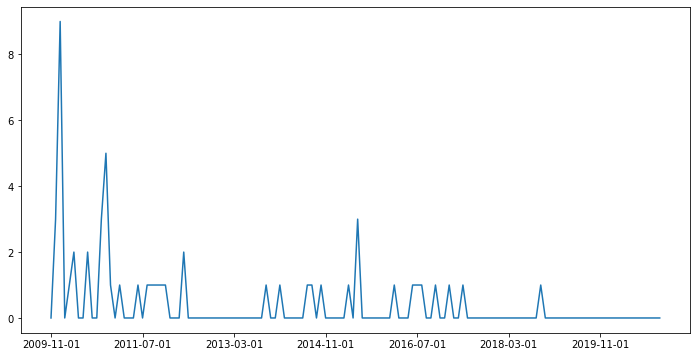

In [386]:
dda.loc[part_number].plot(figsize=(12, 6));

<AxesSubplot:>

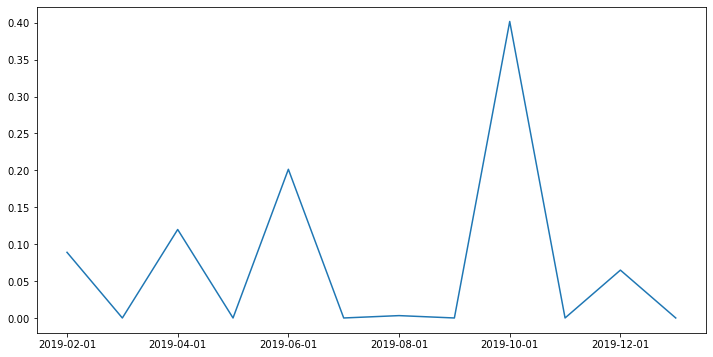

In [387]:
df = fc_aa[fc_aa.REF_CODE==part_number][[col for col in fc_aa.columns if col.find('_')==0]]
df.columns = months_between_list(date_add_months(date, 2), date_add_months(date, 13))
df.squeeze().plot(figsize=(12, 6))

<AxesSubplot:>

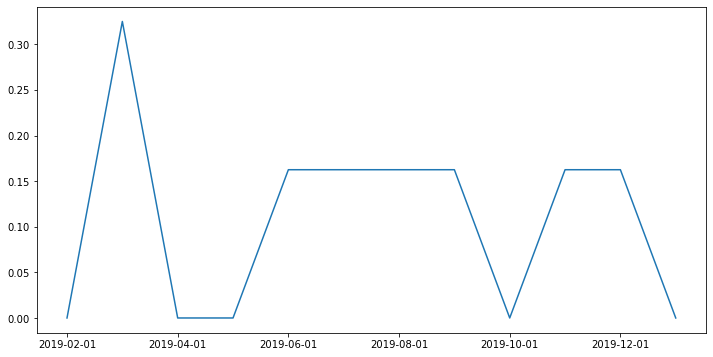

In [388]:
df = fc_bp[fc_bp.REF_CODE==part_number][[col for col in fc_bp.columns if col.find('_')==0]]
df.columns = months_between_list(date_add_months(date, 2), date_add_months(date, 13))
df.squeeze().plot(figsize=(12, 6))

In [371]:
linea

'SSC'

In [372]:
get_dda(linea, base=False, AC=False)

,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,2010-05-01,2010-06-01,2010-07-01,2010-08-01,...,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01
REF_CODE,,,,,,,,,,,,,,,,,,,,,
(A340) 2-1577-8,1,1,0.0,1.0,2.0,1,3.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(DELETED)CE2-40,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0-0-6S,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0-00-21200-50004-6,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0-00-51115-81449-0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZL-4016-10P,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZL-4016-10R,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZL-4116-10P,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
